# Model Performance w.r.t. Resolution

We use two definitions of image resolution, and evaluate model against each:
1. Pixel resolution
2. Spatial resolution

In [1]:
import os
import gc
import sys
import glob

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

In [2]:
ROOT = "../../../Mask_RCNN/"
MODEL_DIR = os.path.join(ROOT, "logs")
COCO_PATH = os.path.join(ROOT, "samples/coco/")
COCO_MODEL_PATH = os.path.join(ROOT + "mask_rcnn_coco.h5")
CLOMASK_PATH = "../../../Mask_RCNN/mrcnn"

sys.path.append(ROOT)
sys.path.append(CLOMASK_PATH)
sys.path.append(COCO_PATH)

import coco
import utils
from model import MaskRCNN

Using TensorFlow backend.


### Initializing the model

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceConfig()
#model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
#model.load_weights(COCO_MODEL_PATH, by_name=True)

We need to be able to programmatically resize images, to reduce pixel resolution. Serendiptously, this also gives us a way to reduce spatial resolution, since we can downsize and then upsize the image.

In [4]:
def resize(img, masks, factor):
    r, c = img.shape[:2]
    r, c = int(r*factor), int(c*factor)
    
    img = Image.fromarray(img, 'RGB').resize((r, c), Image.BICUBIC)
    masks = [Image.fromarray(np.uint8(m), 'L').resize((r, c), Image.BICUBIC) for m in masks]
    
    img = np.array(img)
    masks = np.stack([np.array(m) for m in masks], axis=-1)
    
    return img, masks

## Pixel Resolution

### Directory Structure

The directory structure for this analysis is same as convention:

```
├── pixel
│   └── bottle_h001
│       ├── image
│       │   ├── bottles_h001.jpg
│       └── masks
│           ├── 000_bottle.png
│           ├── 001_bottle.png
│           ├── 002_bottle.png
│           ├── ...
```

For each `resize_factor`, we resize the image and evaluate the performance. A `resize_factor` of 0.5 on an image of size (1024 x 1024) would result in . a (512 x 512) image.

In [5]:
resize_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Since we only want to evaluate the mAP on bottles, we use a small utility function to filter out all results that are not bottles (or any particular class index).

In [6]:
bottle_idx = [40]

def filter_results(r):
    filter_mask = np.isin(r['class_ids'], bottle_idx)
    r['rois'] = r['rois'][filter_mask, :]
    r['scores'] = r['scores'][filter_mask]
    r['class_ids'] = r['class_ids'][filter_mask]
    r['masks'] = r['masks'][:, :, filter_mask]

    return r

We use a small utility function to calculate the mean average precision for bottle masks only:

In [7]:
def evaluate_bottle_mAP(model, img, true_masks):
    """
    Arguments
    ---------
    model: A loaded MaskRCNN model
    
    img: np array
        The input image
        
    true_masks: np array
        An array of ground truth masks
    
    """
    result = model.detect([img], verbose=0)[0]
    result = filter_results(result)
    
    pred_box, pred_class_id, pred_score, pred_mask = result['rois'], result['class_ids'], result['scores'], result['masks']
    k = len(result['masks'])
    
    gt_box = utils.extract_bboxes(true_masks)
    gt_class_id = np.array(bottle_idx*k)
    
    # mean average precision
    mAP = utils.compute_ap_range(gt_box, gt_class_id, true_masks,
                                 pred_box, pred_class_id, pred_score, pred_mask,
                                 iou_thresholds=None, verbose=0)
    
    return mAP

In [8]:
im = plt.imread("./data/pixel/bottle_h001/image/bottles_h001.jpg")
masks = [plt.imread(f)[:, :, 0] for f in glob.glob("./data/pixel/bottle_h001/masks/*.png")]

**Note:** The code below has been written in this peculiar manner deliberately. Running the model repeatedly can cause the kernel to die due to low memory. Since we may want to run this notebook on a local machine, we create, delete and clean up the model in each iteration, even though it is more time consuming

In [9]:
mAPs = []
for resize_factor in resize_factors:
    model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    resized_img, resized_masks = resize(im, masks, resize_factor)
    
    mAP = evaluate_bottle_mAP(model, resized_img, resized_masks)
    del resized_img
    del resized_masks
    del model
    gc.collect()
    
    mAPs.append(mAP)
    print("mAP for {} = {}".format(resize_factor, mAP))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
mAP for 0.1 = 0.3023905856102103
mAP for 0.2 = 0.3442222368717193
mAP for 0.3 = 0.3317037176920308
mAP for 0.4 = 0.3172222344825665
mAP for 0.5 = 0.3320370509806606
mAP for 0.6 = 0.33222223917643234
mAP for 0.7 = 0.33000001683831215
mAP for 0.8 = 0.3222222375373046
mAP for 0.9 = 0.3255555706719558
mAP for 1.0 = 0.3039814952347014


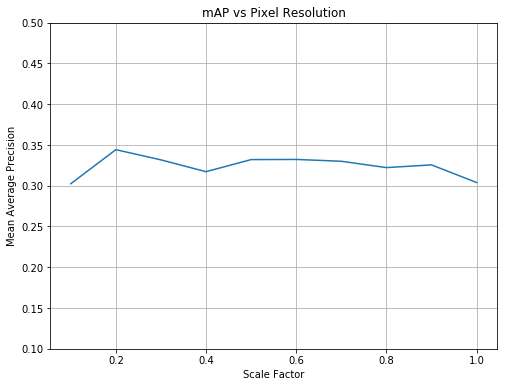

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(resize_factors, mAPs)
plt.xlabel("Scale Factor")
plt.ylabel("Mean Average Precision")
plt.ylim((0.1, 0.5))
plt.grid()
_ = plt.title("mAP vs Pixel Resolution")

## Spatial Resolution